In [1]:
!pip install playwright

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 16.5 MB/s eta 0:00:00


In [2]:
!playwright install --with-deps chromium

Installing dependencies...
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [62.9 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,304 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2

In [3]:
from playwright.async_api import async_playwright

p = await async_playwright().start()
browser = await p.chromium.launch(headless=True)
context = await browser.new_context()
page = await context.new_page()

In [4]:
await page.goto("https://www.pinterest.com")


<Response url='https://www.pinterest.com/' request=<Request url='https://www.pinterest.com/' method='GET'>>

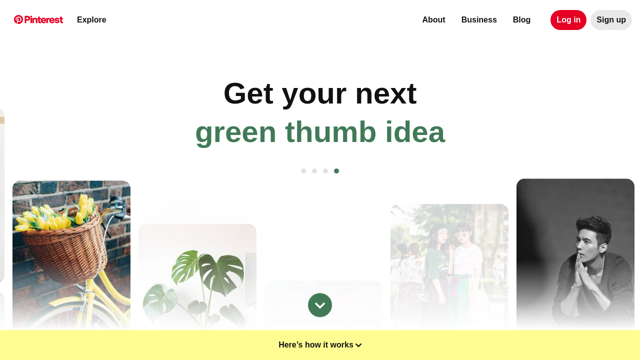

In [5]:
from io import  BytesIO
from PIL import Image as PILImage
from IPython.display import display

screenshot = await page.screenshot()
img = PILImage.open(BytesIO(screenshot))
width, height = img.size
new_width = int(width * 0.5)
new_height = int(height * 0.5)
img = img.resize((new_width, new_height))

display(img)

In [16]:
from pprint import pprint
clickable_elements = await page.query_selector_all('a, button, [role="button"], [onclick]')
labeled_elements = dict()
for index, element in enumerate(clickable_elements):
  text = await element.inner_text()
  cleaned_text= " ".join(text.split())
  if text and await element.is_visible():
    labeled_elements[index] = cleaned_text
pprint(labeled_elements)


{2: 'Explore',
 3: 'About',
 4: 'Business',
 5: 'Blog',
 6: 'Log in',
 7: 'Sign up',
 13: 'Here’s how it works',
 14: 'easy chicken dinner',
 15: 'Explore',
 16: 'Fern future home vibes',
 17: 'My Scandinavian bedroom',
 18: 'The deck of my dreams',
 19: 'Our bathroom upgrade',
 20: 'Serve my drinks in style',
 21: 'Explore',
 22: 'Scout the City 56.7k followers',
 23: 'Explore',
 24: 'Continue',
 25: 'Terms of Service',
 26: 'Privacy Policy',
 27: 'Notice at collection',
 28: 'Log in',
 29: 'Create a free business account',
 31: 'Terms of Service',
 32: 'Privacy Policy',
 33: 'Help',
 34: 'Iphone App',
 35: 'Android App',
 36: 'Users',
 37: 'Collections',
 38: 'Shopping',
 39: 'Explore',
 40: 'Shop'}


In [20]:
await clickable_elements[2].click()

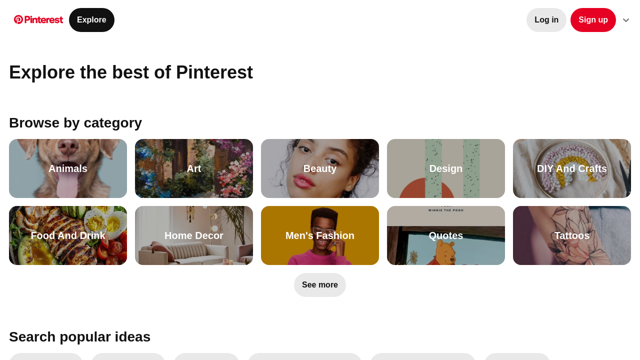

In [21]:

screenshot = await page.screenshot()
img = PILImage.open(BytesIO(screenshot))
width, height = img.size
new_width = int(width * 0.5)
new_height = int(height * 0.5)
img = img.resize((new_width, new_height))

display(img)

In [22]:
from google.colab import userdata
print(userdata.get('TOGETHER_API_KEY_NEW'))

f3fd4f369de2a37d483025350ca645b2ed1ea9599e6b555c4287e3db4b2eac44


In [68]:
from openai import OpenAI
from google.colab import userdata
client = OpenAI(
    base_url="https://api.together.xyz/v1",
    api_key=userdata.get('TOGETHER_API_KEY_NEW')
)

tools = [{
    "type": "function",
    "function": {
        "name": "load_page",
        "description": "Go to a webpage.",
        "parameters": {
            "type": "object",
            "properties": {
                "url": {
                    "type": "string",
                }
            },
            "required": [
                "url"
            ],
            "additionalProperties": False
        },
        "strict": True
    }
}, {
    "type": "function",
    "function": {
        "name": "click_element",
        "description": "Click on an element by ID.",
        "parameters": {
            "type": "object",
            "properties": {
                "element_id": {
                    "type": "number",
                }
            },
            "required": [
                "element_id"
            ],
            "additionalProperties": False
        },
        "strict": True
    }
}]

chat_history =[{"role": "user", "content": "Go to Pinterest and find some interesting images"}]


In [48]:
completion = client.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    messages=chat_history,
    tools=tools
)

print(completion.choices[0].message.content)
print(completion.choices[0].message.tool_calls)

None
[ChatCompletionMessageToolCall(id='call_mlb4k3kt0l7sdke1prnz356e', function=Function(arguments='{"element_id":2}', name='click_element'), type='function', index=0)]


In [71]:
import json

clickable_elements = []

async def get_clickable_elements():
  global clickable_elements
  await page.wait_for_load_state()
  clickable_elements = await page.query_selector_all('a, button, [role="button"], [onclick]')
  labeled_elements = dict()

  for index, element in enumerate(clickable_elements):
    text = await element.inner_text()
    cleaned_text= " ".join(text.split())
    if text and await element.is_visible():
      labeled_elements[index] = cleaned_text

  return "The page has loaded and the following element IDs can be clicked " + json.dumps(labeled_elements)



async def load_page(url):
  await page.goto(url)
  return await get_clickable_elements()

async def click_element(element_id):
  await clickable_elements[element_id].click()
  return await get_clickable_elements()

In [72]:
import json
from playwright.async_api import async_playwright

p = await async_playwright().start()
browser = await p.chromium.launch(headless=True)
context = await browser.new_context()
page = await context.new_page()

chat_history =[{"role": "user", "content": "Go to Pinterest and find interesting images"}]

while True:
  completion = client.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    messages=chat_history,
    tools=tools
)

  print(completion.choices[0].message.content)
  print(completion.choices[0].message.tool_calls)
  tool_calls = completion.choices[0].message.tool_calls
  if tool_calls:
    chat_history.append(completion.choices[0].message)
    tool_call_name= tool_calls[0].function.name
    result = await load_page(url)
    if tool_call_name == "load_page":
      url = json.loads(tool_calls[0].function.arguments)["url"]
      chat_history.append({
          "role": "function",
          "name": tool_call_name,
          "content": result
      })
    print("==================Load page")
    pprint(result)
    if tool_call_name == "click_element":
      element_id = json.loads(tool_calls[0].function.arguments)["element_id"]
      result = await click_element(element_id)
      chat_history.append({
          "role": "function",
          "name": tool_call_name,
          "content": result
      })
      print("==================Click element")
      pprint(result)
  else:
    print("No more tools =========")
    break


None
[ChatCompletionMessageToolCall(id='call_34yhigxygf0ipr7gn14erukb', function=Function(arguments='{"url":"https://www.pinterest.com"}', name='load_page'), type='function', index=0)]
==================Load page
('The page has loaded and the following element IDs can be clicked {"2": '
 '"Explore", "3": "About", "4": "Business", "5": "Blog", "6": "Log in", "7": '
 '"Sign up"}')
None
[ChatCompletionMessageToolCall(id='call_4rm3x3nsyg62sqianc2wohn4', function=Function(arguments='{"element_id":2}', name='click_element'), type='function', index=0)]
==================Load page
('The page has loaded and the following element IDs can be clicked {"2": '
 '"Explore", "3": "About", "4": "Business", "5": "Blog", "6": "Log in", "7": '
 '"Sign up"}')
==================Click element
('The page has loaded and the following element IDs can be clicked {"2": '
 '"Explore", "3": "Log in", "4": "Sign up", "6": "Animals", "7": "Art", "8": '
 '"Beauty", "9": "Design", "10": "DIY And Crafts", "11": "Food An

CancelledError: 

In [60]:
pprint(chat_history)

[{'content': 'Go to Pinterest and find some interesting images',
  'role': 'user'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_k8hzdutvh3lp2o42neh1z25e', function=Function(arguments='{"url":"https://www.pinterest.com"}', name='load_page'), type='function', index=0)]),
 {'content': 'The page has loaded and the following element IDs can be '
             'clicked{"2": "Explore", "3": "About", "4": "Business", "5": '
             '"Blog", "6": "Log in", "7": "Sign up"}',
  'name': 'load_page',
  'role': 'function'}]


In [73]:
screenshot = await page.screenshot()
img = PILImage.open(BytesIO(screenshot))
width, height = img.size
new_width = int(width * 0.5)
new_height = int(height * 0.5)
img = img.resize((new_width, new_height))

display(img)

Exception: Page.screenshot: Connection closed while reading from the driver